In [6]:
from marc_dataframes import loc
import itertools

records = list(itertools.islice(loc.load_from_xml('datasets/BooksAll.part01.xml.frag_02'), 10000))
print("Loaded %i records" % len(records))

Loaded 10000 records


In [7]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import kneighbors_graph
from marc_dataframes import marc

FIELDS = marc.select(marc.AllFields)

hv = HashingVectorizer(n_features = 10000, ngram_range = (1, 2), stop_words='english')
tfidf = TfidfTransformer()

vectorizer = Pipeline([
    ('features', FeatureUnion(
        list(map(lambda field: (field, Pipeline([
            ('read xml', loc.LOCTransformer([field])),
            ('flatten', loc.FlattenTransformer()),
            ('hash, tf-idf', Pipeline([
                ('hash', hv),
                ('tf-idf', tfidf)
            ]))
        ])), FIELDS))
    )),
    ('reduce dimensions', TruncatedSVD(300)),
    ('normalize to unit value', Normalizer(copy = False))
])

X = vectorizer.fit_transform(records)

clustering = AgglomerativeClustering(
        n_clusters = 10,
        connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False))

model = Pipeline([
    ('cluster', clustering)
])

model.fit(X)

/home/mmp/anaconda3/lib/python3.6/site-packages/sklearn/cluster/hierarchical.py:193: UserWarning: the number of connected components of the connectivity matrix is 17 > 1. Completing it to avoid stopping the tree early.
  affinity='euclidean')


Pipeline(memory=None,
     steps=[('cluster', AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=<10000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 100000 stored elements in Compressed Sparse Row format>,
            linkage='ward', memory=None, n_clusters=10,
            pooling_func=<function mean at 0x7f9c0c0bce18>))])

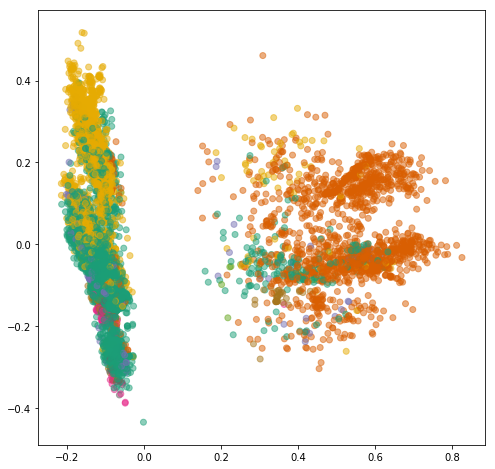

In [8]:
# Visualize the records in two dimensions with PCA, color by cluster.

import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.decomposition import PCA

X_pca = PCA(2).fit_transform(X)

plt.figure(figsize=(8, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clustering.labels_, cmap = 'Dark2', alpha = 0.5)